In [1]:
%load_ext autoreload
%autoreload 2

import sys
from lifting_rl.linkage_env import LinkageEnv
from livelossplot import PlotLosses
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifting_rl.ddpg.model import Critic, Actor
from lifting_rl.ddpg.utils import OUNoise, NormalizedEnv, Memory
from lifting_rl.ddpg.agent import DDPGagent

In [2]:
params = {
    "N_LINKS": 1,
    "GOAL_POS": np.array([np.pi / 4, 0], dtype=np.float32),
    "INIT_STATE": np.array([np.pi / 4, 0], dtype=np.float32),
    "PARAM_VALS": np.array([9.81, 0.4, 1], dtype=np.float32),
    "OBS_LOW": np.array([-np.pi, -8 * np.pi], dtype=np.float32),
    "OBS_HIGH": np.array(
        [np.pi, 8 * np.pi], dtype=np.float32
    ),
    "ACT_LOW": -30,
    "ACT_HIGH": 30,
    "TIME_STEP": 0.01,
    "VIDEO_FPS": 30,
}


In [3]:
angles_file = "../data/skeleton_angles.csv"

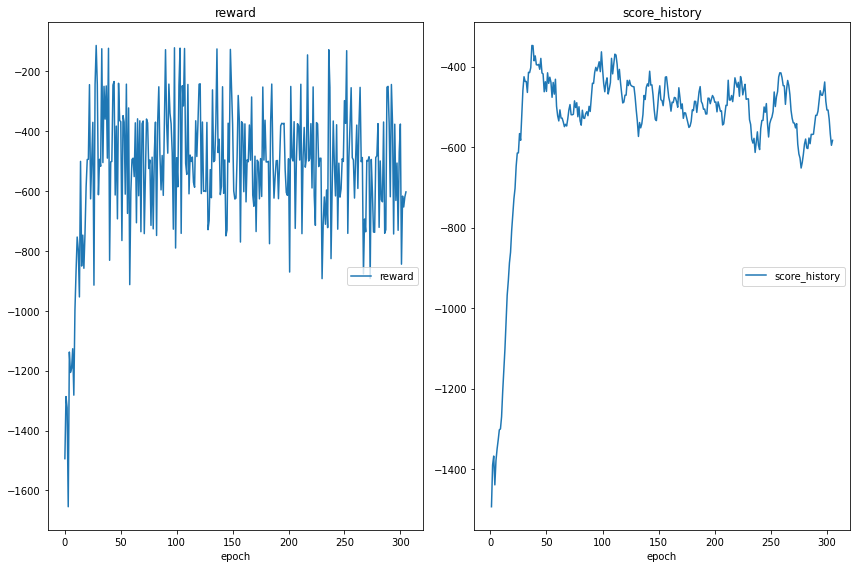

reward
	reward           	 (min: -1654.266, max: -114.761, cur: -603.557)
score_history
	score_history    	 (min:      nan, max:      nan, cur: -583.241)
episode: 306, reward: -496.48, average _reward: -605.8405589411007 


In [ ]:
env = gym.make("Pendulum-v0") #LinkageEnv(angles_file, params, verbose=0)

agent = DDPGagent(env, device = 'cuda:0')
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

liveloss = PlotLosses()

for episode in range(10000):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in range(500):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(
                episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:]))
            )
            break
    
    metrics = {
        "score_history": np.mean(rewards[-10:]),
        "reward": episode_reward
    }
    liveloss.update(metrics)
    liveloss.send()
    
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

# plt.plot(rewards)
# plt.plot(avg_rewards)
# plt.plot()
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.show()

In [ ]:
rewards